In [1]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms as T
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.io import loadmat 

class PhotometricStereoDataset(Dataset):
    def __init__(self, folder):
        self.folder = folder
        self.image_paths = [os.path.join(folder, f"{i:03}.png") for i in range(1, 97)]
        self.mask_path = os.path.join(folder, "mask.png")
        self.normal_gt_mat_path = os.path.join(folder, "Normal_gt.mat")
        self.to_tensor = T.ToTensor()

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        imgs = [self.to_tensor(Image.open(p).convert("L")) for p in self.image_paths]
        imgs = torch.cat(imgs, dim=0)  

        mask = self.to_tensor(Image.open(self.mask_path))[0]  

        mat = loadmat(self.normal_gt_mat_path)
        normal_np = mat['Normal_gt'] 
        normal = torch.from_numpy(normal_np).permute(2, 0, 1).float()  

        if normal.max() > 1.0 or normal.min() < -1.0:
            normal = normal * 2 - 1

        return imgs, normal, mask

class SimpleNormalEstimator(nn.Module):
    def __init__(self, in_channels=96, out_channels=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, out_channels, 3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

def normal_loss(pred, target, mask):
    pred = F.normalize(pred, dim=1)
    target = F.normalize(target, dim=1)


    mask = mask.unsqueeze(1)  

    loss = 1 - (pred * target).sum(dim=1, keepdim=True)  # [B, 1, H, W]

    return (loss * mask).mean()


train_folders = [
    "../DiLiGenT/pmsData/catPNG/",
    "../DiLiGenT/pmsData/cowPNG/",
    "../DiLiGenT/pmsData/buddhaPNG/",
    "../DiLiGenT/pmsData/ballPNG/",
    "../DiLiGenT/pmsData/bearPNG/",
    "../DiLiGenT/pmsData/gobletPNG/",
    "../DiLiGenT/pmsData/readingPNG/",
     "../DiLiGenT/pmsData/pot2PNG/"
]

train_datasets = [PhotometricStereoDataset(folder) for folder in train_folders]
train_loader = DataLoader(ConcatDataset(train_datasets), batch_size=1, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNormalEstimator().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for imgs, normals, mask in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        imgs, normals, mask = imgs.to(device), normals.to(device), mask.to(device)
        optimizer.zero_grad()
        pred = model(imgs)
        loss = normal_loss(pred, normals, mask)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")


torch.save(model.state_dict(), "normal_estimator_pot1.pth")
set_seed(42)  
model = SimpleNormalEstimator().to(device)
model.load_state_dict(torch.load("normal_estimator_pot1.pth"))



test_folder = "../DiLiGenT/pmsData/pot1PNG/"
test_dataset = PhotometricStereoDataset(test_folder)
imgs, _, _ = test_dataset[0] 
imgs = imgs.unsqueeze(0).to(device) 

model.eval()
with torch.no_grad():
    pred = model(imgs)[0].cpu()  
    predk=pred
    pred = (pred + 1) / 2  




Epoch 1/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1 Loss: 0.0279


Epoch 2/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2 Loss: 0.0106


Epoch 3/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3 Loss: 0.0073


Epoch 4/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4 Loss: 0.0077


Epoch 5/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 Loss: 0.0077


Epoch 6/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 6 Loss: 0.0069


Epoch 7/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 7 Loss: 0.0062


Epoch 8/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 8 Loss: 0.0055


Epoch 9/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 9 Loss: 0.0052


Epoch 10/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 10 Loss: 0.0054


Epoch 11/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 11 Loss: 0.0052


Epoch 12/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 12 Loss: 0.0064


Epoch 13/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 13 Loss: 0.0057


Epoch 14/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 14 Loss: 0.0054


Epoch 15/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 15 Loss: 0.0053


Epoch 16/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 16 Loss: 0.0055


Epoch 17/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 17 Loss: 0.0056


Epoch 18/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 18 Loss: 0.0054


Epoch 19/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 19 Loss: 0.0053


Epoch 20/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 20 Loss: 0.0051


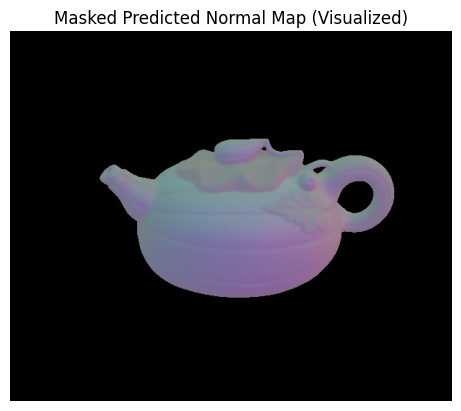

In [3]:
from torchvision import transforms as T
from PIL import Image
import torch
import matplotlib.pyplot as plt


mask_path = "../DiLiGenT/pmsData/pot1PNG/mask.png"
to_tensor = T.ToTensor()
test_mask = to_tensor(Image.open(mask_path).convert("L"))  # shape: (1, H, W)
test_mask = (test_mask > 0).float()

masked_pred = predk * test_mask  

normalized_pred = (predk + 1.0) / 2.0  
masked_normal_vis = normalized_pred * test_mask  

pred_np = masked_normal_vis.permute(1, 2, 0).cpu().numpy()

plt.imshow(pred_np)
plt.title("Masked Predicted Normal Map (Visualized)")
plt.axis("off")
plt.show()


In [4]:
import cv2
mask = cv2.imread(os.path.join("../DiLiGenT/pmsData/pot1PNG/", "mask.png"), 0)
mask = (mask > 200)
mask.shape

(512, 612)

In [5]:

normal_gt_path = os.path.join("../DiLiGenT/pmsData/pot1PNG/", "normal.txt")
normal_gt = np.loadtxt(normal_gt_path)  
normal_gt = normal_gt.reshape(mask.shape[0], mask.shape[1], 3)  

normal_mapk=masked_pred

normal_mapk = normal_mapk.detach().cpu().numpy()
if normal_gt.shape[0] == 3:
    normal_gt = np.transpose(normal_gt, (1, 2, 0))  

if normal_mapk.shape[0] == 3:
    normal_mapk = np.transpose(normal_mapk, (1, 2, 0))  


# print(normal_gt.shape)
# print(normal_mapk.shape)

norm_pred = normal_mapk / (np.linalg.norm(normal_mapk, axis=2, keepdims=True) + 1e-6)
norm_gt = normal_gt / (np.linalg.norm(normal_gt, axis=2, keepdims=True) + 1e-6)

dot_product = np.sum(norm_pred * norm_gt, axis=2)
dot_product = np.clip(dot_product, -1.0, 1.0)  

angular_error = np.arccos(dot_product) * (180.0 / np.pi)

angular_error[~mask] = np.nan

mean_angular_error = np.nanmean(angular_error)
print(f"Mean Angular Error: {mean_angular_error:.2f} degrees")


Mean Angular Error: 9.76 degrees


In [6]:
import scipy.io as sio
sio.savemat("Normal_pred_pot.mat", {"Normal_pred": masked_pred})
print("Saved to Normal_pred.mat")


Saved to Normal_pred.mat


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
(512, 612, 3)


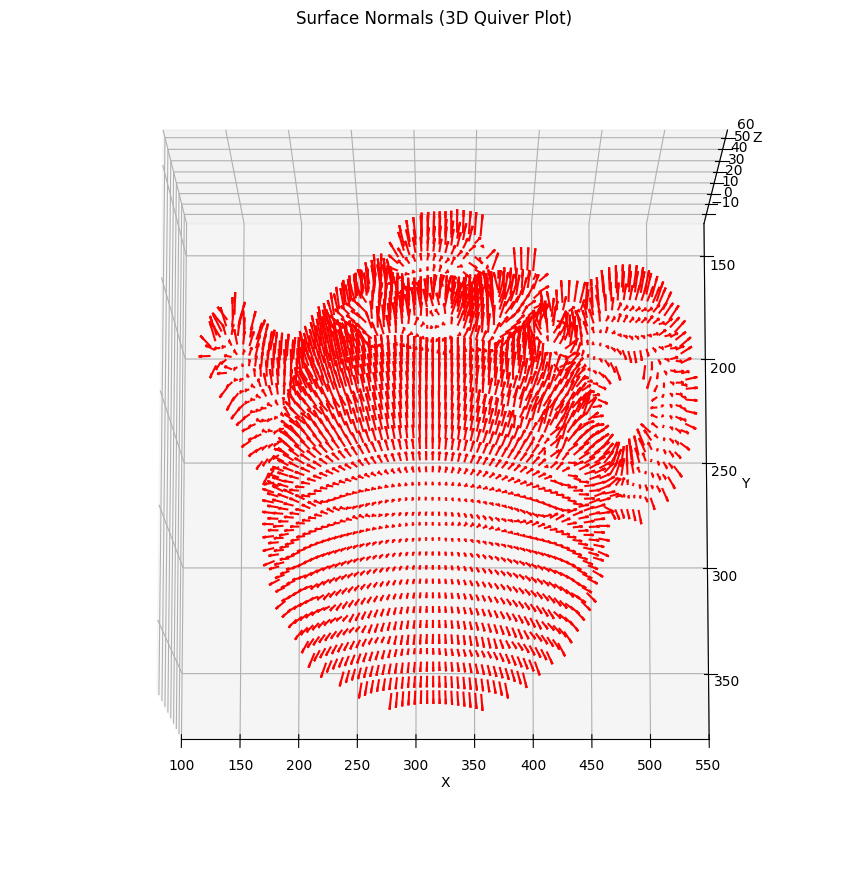

In [7]:
import cv2
import numpy as np
import os
from scipy.io import loadmat
import open3d as o3d
from numpy.fft import fft2, ifft2

def frankot_chellappa(p, q):
    """Integrate p, q (gradients along x, y) using Frankot-Chellappa method."""
    h, w = p.shape
    wx = np.tile(np.fft.fftfreq(w), (h, 1))
    wy = np.tile(np.fft.fftfreq(h), (w, 1)).T

    Px = fft2(p)
    Qy = fft2(q)

    denom = (2 * np.pi * wx) ** 2 + (2 * np.pi * wy) ** 2
    denom[0, 0] = 1  # avoid divide by zero

    Z = (-1j * 2 * np.pi * wx * Px - 1j * 2 * np.pi * wy * Qy) / denom
    z = np.real(ifft2(Z))

    return z

def depth_from_normals(normals, mask):
    """Compute depth map from normals and mask."""
    nz = normals[:, :, 2]
    nz[nz == 0] = 1e-6  

    p = -normals[:, :, 0] / nz
    q = -normals[:, :, 1] / nz


    p[~mask] = 0
    q[~mask] = 0

    depth = frankot_chellappa(p, q)
    return depth

def save_mesh(depth, normals, mask, filename):
    """Convert depth and normals to mesh and save as .ply file."""
    h, w = depth.shape
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    points = np.stack((xx, yy, depth), axis=2).reshape(-1, 3)
    normals = normals.reshape(-1, 3)
    mask = mask.flatten()

    points = points[mask]
    normals = normals[mask]

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.normals = o3d.utility.Vector3dVector(normals)

    pcd.estimate_normals()
    pcd.orient_normals_consistent_tangent_plane(10)
    distances = pcd.compute_nearest_neighbor_distance()
    avg_dist = np.mean(distances)
    radius = 2 * avg_dist

    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
        pcd, o3d.utility.DoubleVector([radius, radius * 2])
    )

    o3d.io.write_triangle_mesh(filename, mesh)


image_folder = "../DiLiGenT/pmsData/pot1PNG/"
mask_path = os.path.join(image_folder, "mask.png")
mat_path = os.path.join("./Normal_pred_pot.mat")


mask = cv2.imread(mask_path, 0)
mask = (mask > 0)  


mat_data = loadmat(mat_path)
normal_map = mat_data["Normal_pred"]  

if normal_map.shape[0] == 3 and normal_map.shape[2] != 3:
    normal_map = np.transpose(normal_map, (1, 2, 0))


print(normal_map.shape)


normal_map = normal_map.astype(np.float32)
normal_map[:, :, 1] *= -1  
normal_map[:, :, 2] *= -1  


depth = depth_from_normals(normal_map, mask)


H, W = depth.shape

Nx = normal_map[:, :, 0]
Ny = normal_map[:, :, 1]
Nz = normal_map[:, :, 2]

X_coords = np.arange(W)
Y_coords = np.arange(H)
X, Y = np.meshgrid(X_coords, Y_coords)


step = 5 
X_plot = X[::step, ::step]
Y_plot = Y[::step, ::step]
Z_plot = depth[::step, ::step]
Nx_plot = Nx[::step, ::step]
Ny_plot = Ny[::step, ::step]
Nz_plot = Nz[::step, ::step]


Z_plot = -Z_plot
Nz_plot = -Nz_plot


mask_small = mask[::step, ::step]
X_plot = X_plot[mask_small]
Y_plot = Y_plot[mask_small]
Z_plot = Z_plot[mask_small]
Nx_plot = Nx_plot[mask_small]
Ny_plot = Ny_plot[mask_small]
Nz_plot = Nz_plot[mask_small]


fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X_plot, Y_plot, Z_plot, Nx_plot, Ny_plot, Nz_plot,
          length=10.0, normalize=True, color='r')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Surface Normals (3D Quiver Plot)')
ax.view_init(elev=80, azim=90)
ax.set_xlim(550,100)
plt.tight_layout()
plt.show()


save_mesh(depth, normal_map, mask, "./generated_mesh/pot_deep_learning.ply")



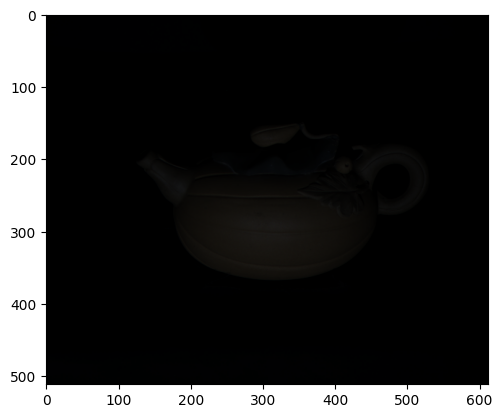

In [8]:
import matplotlib.pyplot as plt
color_img_path = os.path.join(image_folder, "./001.png")
color_img = cv2.imread(color_img_path)
color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)  
plt.imshow(color_img)

In [9]:
color_img = color_img.astype(np.float32) / 255.0  
colors = color_img.reshape(-1, 3)
colors = colors[mask.flatten()]


In [10]:
def save_mesh(depth, normals, mask, filename, colors=None):
    h, w = depth.shape
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    points = np.stack((xx, yy, depth), axis=2).reshape(-1, 3)
    normals = normals.reshape(-1, 3)
    mask = mask.flatten()

    points = points[mask]
    normals = normals[mask]

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.normals = o3d.utility.Vector3dVector(normals)
    
    if colors is not None:
        pcd.colors = o3d.utility.Vector3dVector(colors)

    pcd.estimate_normals()
    pcd.orient_normals_consistent_tangent_plane(10)
    distances = pcd.compute_nearest_neighbor_distance()
    avg_dist = np.mean(distances)
    radius = 2 * avg_dist

    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
        pcd, o3d.utility.DoubleVector([radius, radius * 2])
    )

    o3d.io.write_triangle_mesh(filename, mesh)


In [11]:
save_mesh(depth, normal_map, mask, "./generated_mesh/pot_colored_mesh.ply", colors=colors)


#### Mesh
![Mesh Animation.gif](./generated_mesh/ImageToStl.com_pot_deep_learning+(6).ply.gif)


#### Mesh Color
![Mesh Animation.gif](./generated_mesh/ImageToStl.com_pot_colored_mesh+(6).ply.gif)


#### Another Object

In [12]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


In [13]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms as T
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.io import loadmat  

class PhotometricStereoDataset(Dataset):
    def __init__(self, folder):
        self.folder = folder
        self.image_paths = [os.path.join(folder, f"{i:03}.png") for i in range(1, 97)]
        self.mask_path = os.path.join(folder, "mask.png")
        self.normal_gt_mat_path = os.path.join(folder, "Normal_gt.mat")
        self.to_tensor = T.ToTensor()

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        imgs = [self.to_tensor(Image.open(p).convert("L")) for p in self.image_paths]
        imgs = torch.cat(imgs, dim=0) 

        mask = self.to_tensor(Image.open(self.mask_path))[0]  

        mat = loadmat(self.normal_gt_mat_path)
        normal_np = mat['Normal_gt'] 
        normal = torch.from_numpy(normal_np).permute(2, 0, 1).float()  

        if normal.max() > 1.0 or normal.min() < -1.0:
            normal = normal * 2 - 1

        return imgs, normal, mask

class SimpleNormalEstimator(nn.Module):
    def __init__(self, in_channels=96, out_channels=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, out_channels, 3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

def normal_loss(pred, target, mask):
    pred = F.normalize(pred, dim=1)
    target = F.normalize(target, dim=1)

    mask = mask.unsqueeze(1)  

    loss = 1 - (pred * target).sum(dim=1, keepdim=True)  

    return (loss * mask).mean()


train_folders = [
    "../DiLiGenT/pmsData/catPNG/",
    "../DiLiGenT/pmsData/cowPNG/",
    "../DiLiGenT/pmsData/pot1PNG/",
    "../DiLiGenT/pmsData/ballPNG/",
    "../DiLiGenT/pmsData/bearPNG/",
    "../DiLiGenT/pmsData/gobletPNG/",
    "../DiLiGenT/pmsData/readingPNG/",
     "../DiLiGenT/pmsData/pot2PNG/"
]

train_datasets = [PhotometricStereoDataset(folder) for folder in train_folders]
train_loader = DataLoader(ConcatDataset(train_datasets), batch_size=1, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNormalEstimator().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for imgs, normals, mask in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        imgs, normals, mask = imgs.to(device), normals.to(device), mask.to(device)
        optimizer.zero_grad()
        pred = model(imgs)
        loss = normal_loss(pred, normals, mask)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")


torch.save(model.state_dict(), "normal_estimator_buddha.pth")
set_seed(42)  
model = SimpleNormalEstimator().to(device)
model.load_state_dict(torch.load("normal_estimator_buddha.pth"))

test_folder = "../DiLiGenT/pmsData/buddhaPNG/"
test_dataset = PhotometricStereoDataset(test_folder)
imgs, _, _ = test_dataset[0] 
imgs = imgs.unsqueeze(0).to(device) 

model.eval()
with torch.no_grad():
    pred = model(imgs)[0].cpu()  
    predk=pred
    pred = (pred + 1) / 2  





Epoch 1/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1 Loss: 0.0294


Epoch 2/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2 Loss: 0.0118


Epoch 3/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3 Loss: 0.0075


Epoch 4/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4 Loss: 0.0077


Epoch 5/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 Loss: 0.0075


Epoch 6/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 6 Loss: 0.0066


Epoch 7/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 7 Loss: 0.0066


Epoch 8/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 8 Loss: 0.0058


Epoch 9/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 9 Loss: 0.0052


Epoch 10/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 10 Loss: 0.0047


Epoch 11/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 11 Loss: 0.0046


Epoch 12/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 12 Loss: 0.0047


Epoch 13/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 13 Loss: 0.0047


Epoch 14/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 14 Loss: 0.0043


Epoch 15/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 15 Loss: 0.0047


Epoch 16/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 16 Loss: 0.0048


Epoch 17/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 17 Loss: 0.0059


Epoch 18/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 18 Loss: 0.0050


Epoch 19/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 19 Loss: 0.0048


Epoch 20/20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 20 Loss: 0.0045


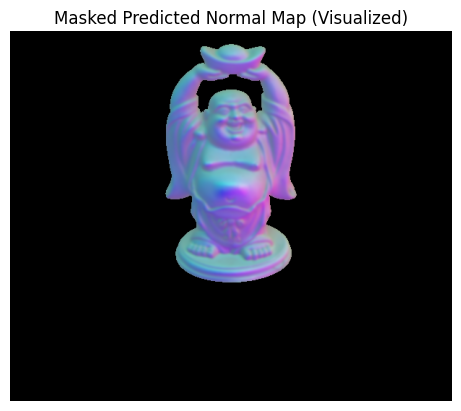

In [14]:
from torchvision import transforms as T
from PIL import Image
import torch
import matplotlib.pyplot as plt

mask_path = "../DiLiGenT/pmsData/buddhaPNG/mask.png"
to_tensor = T.ToTensor()
test_mask = to_tensor(Image.open(mask_path).convert("L"))  
test_mask = (test_mask > 0).float()

masked_pred = predk * test_mask  

normalized_pred = (predk + 1.0) / 2.0  
masked_normal_vis = normalized_pred * test_mask  

pred_np = masked_normal_vis.permute(1, 2, 0).cpu().numpy()

plt.imshow(pred_np)
plt.title("Masked Predicted Normal Map (Visualized)")
plt.axis("off")
plt.show()


In [15]:
import cv2
mask = cv2.imread(os.path.join("../DiLiGenT/pmsData/buddhaPNG/", "mask.png"), 0)
mask = (mask > 200)
mask.shape

(512, 612)

In [16]:

normal_gt_path = os.path.join("../DiLiGenT/pmsData/buddhaPNG/", "normal.txt")
normal_gt = np.loadtxt(normal_gt_path)  
normal_gt = normal_gt.reshape(mask.shape[0], mask.shape[1], 3)  

normal_mapk=masked_pred

normal_mapk = normal_mapk.detach().cpu().numpy()
if normal_gt.shape[0] == 3:
    normal_gt = np.transpose(normal_gt, (1, 2, 0))  

if normal_mapk.shape[0] == 3:
    normal_mapk = np.transpose(normal_mapk, (1, 2, 0))  


norm_pred = normal_mapk / (np.linalg.norm(normal_mapk, axis=2, keepdims=True) + 1e-6)
norm_gt = normal_gt / (np.linalg.norm(normal_gt, axis=2, keepdims=True) + 1e-6)

dot_product = np.sum(norm_pred * norm_gt, axis=2)
dot_product = np.clip(dot_product, -1.0, 1.0)  

angular_error = np.arccos(dot_product) * (180.0 / np.pi)

angular_error[~mask] = np.nan

mean_angular_error = np.nanmean(angular_error)
print(f"Mean Angular Error: {mean_angular_error:.2f} degrees")


Mean Angular Error: 18.46 degrees


In [17]:
import scipy.io as sio
sio.savemat("Normal_pred_buddha.mat", {"Normal_pred": masked_pred})
print("Saved to Normal_pred.mat")


Saved to Normal_pred.mat


(512, 612, 3)


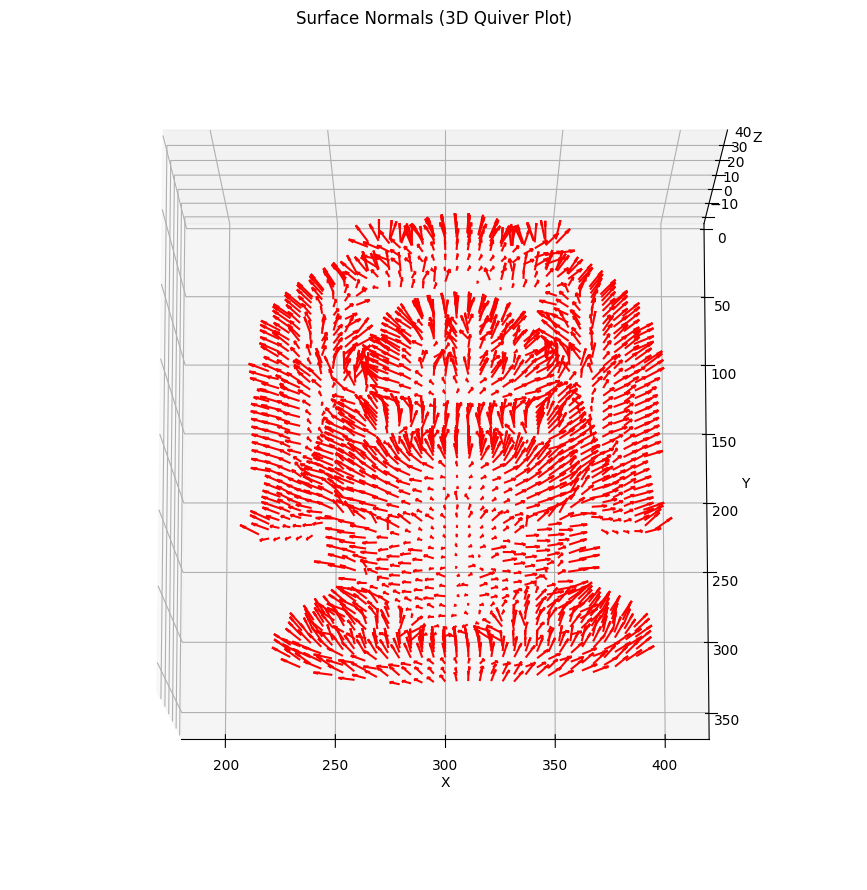

In [18]:
import cv2
import numpy as np
import os
from scipy.io import loadmat
import open3d as o3d
from numpy.fft import fft2, ifft2

def frankot_chellappa(p, q):
    """Integrate p, q (gradients along x, y) using Frankot-Chellappa method."""
    h, w = p.shape
    wx = np.tile(np.fft.fftfreq(w), (h, 1))
    wy = np.tile(np.fft.fftfreq(h), (w, 1)).T

    Px = fft2(p)
    Qy = fft2(q)

    denom = (2 * np.pi * wx) ** 2 + (2 * np.pi * wy) ** 2
    denom[0, 0] = 1  # avoid divide by zero

    Z = (-1j * 2 * np.pi * wx * Px - 1j * 2 * np.pi * wy * Qy) / denom
    z = np.real(ifft2(Z))

    return z

def depth_from_normals(normals, mask):
    """Compute depth map from normals and mask."""
    nz = normals[:, :, 2]
    nz[nz == 0] = 1e-6  

    p = -normals[:, :, 0] / nz
    q = -normals[:, :, 1] / nz


    p[~mask] = 0
    q[~mask] = 0

    depth = frankot_chellappa(p, q)
    return depth

def save_mesh(depth, normals, mask, filename):
    """Convert depth and normals to mesh and save as .ply file."""
    h, w = depth.shape
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    points = np.stack((xx, yy, depth), axis=2).reshape(-1, 3)
    normals = normals.reshape(-1, 3)
    mask = mask.flatten()

    points = points[mask]
    normals = normals[mask]

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.normals = o3d.utility.Vector3dVector(normals)

    pcd.estimate_normals()
    pcd.orient_normals_consistent_tangent_plane(10)
    distances = pcd.compute_nearest_neighbor_distance()
    avg_dist = np.mean(distances)
    radius = 2 * avg_dist

    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
        pcd, o3d.utility.DoubleVector([radius, radius * 2])
    )

    o3d.io.write_triangle_mesh(filename, mesh)


image_folder = "../DiLiGenT/pmsData/buddhaPNG/"
mask_path = os.path.join(image_folder, "mask.png")
mat_path = os.path.join("./Normal_pred_buddha.mat")


mask = cv2.imread(mask_path, 0)
mask = (mask > 0)  


mat_data = loadmat(mat_path)
normal_map = mat_data["Normal_pred"]  

if normal_map.shape[0] == 3 and normal_map.shape[2] != 3:
    normal_map = np.transpose(normal_map, (1, 2, 0))


print(normal_map.shape)


normal_map = normal_map.astype(np.float32)
normal_map[:, :, 1] *= -1  
normal_map[:, :, 2] *= -1  


depth = depth_from_normals(normal_map, mask)


H, W = depth.shape

Nx = normal_map[:, :, 0]
Ny = normal_map[:, :, 1]
Nz = normal_map[:, :, 2]

X_coords = np.arange(W)
Y_coords = np.arange(H)
X, Y = np.meshgrid(X_coords, Y_coords)


step = 5 
X_plot = X[::step, ::step]
Y_plot = Y[::step, ::step]
Z_plot = depth[::step, ::step]
Nx_plot = Nx[::step, ::step]
Ny_plot = Ny[::step, ::step]
Nz_plot = Nz[::step, ::step]


Z_plot = -Z_plot
Nz_plot = -Nz_plot


mask_small = mask[::step, ::step]
X_plot = X_plot[mask_small]
Y_plot = Y_plot[mask_small]
Z_plot = Z_plot[mask_small]
Nx_plot = Nx_plot[mask_small]
Ny_plot = Ny_plot[mask_small]
Nz_plot = Nz_plot[mask_small]


fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X_plot, Y_plot, Z_plot, Nx_plot, Ny_plot, Nz_plot,
          length=10.0, normalize=True, color='r')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Surface Normals (3D Quiver Plot)')
ax.view_init(elev=80, azim=90)
ax.set_xlim(420,180)
plt.tight_layout()
plt.show()


save_mesh(depth, normal_map, mask, "./generated_mesh/buddha_deep_learning.ply")



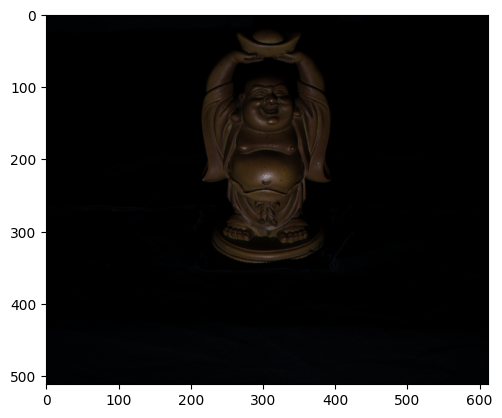

In [19]:
import matplotlib.pyplot as plt
color_img_path = os.path.join(image_folder, "./001.png")
color_img = cv2.imread(color_img_path)
color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
plt.imshow(color_img)

In [20]:
color_img = color_img.astype(np.float32) / 255.0  # Normalize to [0, 1]
colors = color_img.reshape(-1, 3)
colors = colors[mask.flatten()]


In [21]:
def save_mesh(depth, normals, mask, filename, colors=None):
    h, w = depth.shape
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    points = np.stack((xx, yy, depth), axis=2).reshape(-1, 3)
    normals = normals.reshape(-1, 3)
    mask = mask.flatten()

    points = points[mask]
    normals = normals[mask]

    # Create point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.normals = o3d.utility.Vector3dVector(normals)
    
    if colors is not None:
        pcd.colors = o3d.utility.Vector3dVector(colors)

    # Ball pivoting for mesh
    pcd.estimate_normals()
    pcd.orient_normals_consistent_tangent_plane(10)
    distances = pcd.compute_nearest_neighbor_distance()
    avg_dist = np.mean(distances)
    radius = 2 * avg_dist

    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
        pcd, o3d.utility.DoubleVector([radius, radius * 2])
    )

    o3d.io.write_triangle_mesh(filename, mesh)


In [22]:
save_mesh(depth, normal_map, mask, "./generated_mesh/buddha_colored_mesh.ply", colors=colors)


#### Mesh
![Mesh Animation.gif](./generated_mesh/ImageToStl.com_buddha_deep_learning+(2).ply.gif)


#### Mesh Color
![Mesh Animation.gif](./generated_mesh/ImageToStl.com_buddha_colored_mesh+(6).ply.gif)
